In [5]:
import os
import pycountry
import pandas as pd
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from copy import deepcopy

from plotting_constants import coarse_regions

from data_path import DATA_PATH as root

def dict_list(dict):
    aslist = list()

    for value in dict.values():
        aslist += value

    return aslist

regions = gpd.read_file(root / "regions_onshore_elec_s_72.geojson")
regions = regions.set_index("name")
regions["name"] = regions.index

def make_region_mapper():

    result = deepcopy(coarse_regions)
    covered = dict_list(result)

    for bus in regions.index:

        if bus in covered:
            continue

        result[pycountry.countries.get(alpha_2=bus[:2]).name] = [bus]

    return result

mapper = make_region_mapper()
reverse_mapper = dict()

for key, values in mapper.items():
    for value in values:
        reverse_mapper[value] = key

regions["region"] = regions["name"].apply(lambda entry: reverse_mapper[entry])
regions

,geometry,name,region
name,,,
AL1 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",AL1 0,"Bosnia, Montenegro,\nAlbania, Croatia"
AT1 0,"POLYGON ((13.86068 46.51525, 13.67026 46.51871...",AT1 0,Austria
BA1 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...",BA1 0,"Bosnia, Montenegro,\nAlbania, Croatia"
BE1 0,"POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...",BE1 0,Benelux
BG1 0,"POLYGON ((23.94989 41.43758, 23.8948 41.46434,...",BG1 0,"Romania, Bulgaria,\nSerbia, Hungary"
...,...,...,...
RS1 0,"POLYGON ((20.7505 41.9068, 20.72331 41.86662, ...",RS1 0,"Romania, Bulgaria,\nSerbia, Hungary"
SE2 0,"MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...",SE2 0,Scandinavia (w/o DK)
SE2 1,"MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...",SE2 1,Scandinavia (w/o DK)


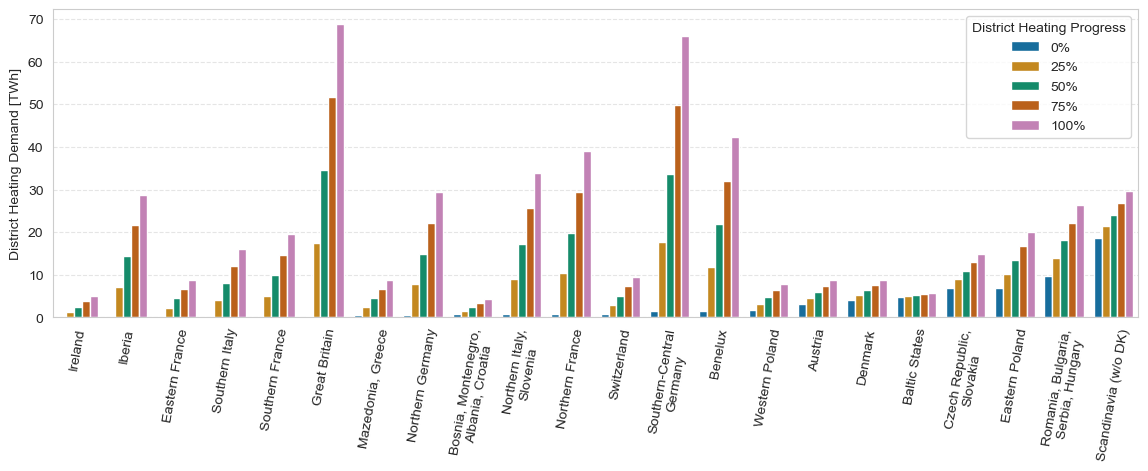

In [7]:
progresses = ["00", "025", "05", "075", "1"]
nice_progress = {"00": "0%", "025": "25%", "05": "50%", "075": "75%", "1": "100%"}

base = root / "district_heating_totals"
file = "chp_{}"

mode = "total"

dh = pd.DataFrame(columns=["loads", "District Heating Progress", "bus"])

for pro in progresses:

    loads = pd.read_csv(
        str(base / file.format(pro)  / "loads_t_pset.csv"),
        index_col=0,
        parse_dates=True
        )

    idx = loads.columns[loads.columns.str.contains("urban central")]
    ss = (
        loads[idx]
        .sum()
        .mul(1e-6)
        .reset_index()
        .rename(columns={"index": "bus", 0: "loads"})
    )

    if mode == "share":

        total = deepcopy(ss)

        for carrier in ["residential urban decentral heat", "services urban decentral heat"]:
            idx = loads.columns[loads.columns.str.contains(carrier)]

            other = (
                loads[idx]
                .sum()
                .mul(1e-6)
                .reset_index()
                .rename(columns={"index": "bus", 0: "loads"})
            )

            total["loads"] = total["loads"] + other["loads"]
        
        new_total = pd.DataFrame(columns=total.columns) 
        total.index = total.bus.str[:5]

        for region, buses in mapper.items():
            new_total.loc[region] = total.loc[total.index.intersection(buses)].sum()
            new_total.at[region, "bus"] = region
        
        total = new_total

    new_ss = pd.DataFrame(columns=ss.columns) 
    ss.index = ss.bus.str[:5]

    for region, buses in mapper.items():
        new_ss.loc[region] = ss.loc[ss.index.intersection(buses)].sum()
        new_ss.at[region, "bus"] = region
    
    ss = new_ss

    ss["bus"] = ss.index

    if mode == "share":
        ss["loads"] /= total["loads"]

    ss["District Heating Progress"] = pd.Series(nice_progress[pro], index=ss.index)

    dh = pd.concat((dh, ss))

dh.index = range(len(dh))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
dh = dh.sort_values("loads", ascending=True)

sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.barplot(dh, x="bus", y="loads", hue="District Heating Progress")


plot_regions = sorted([
    'Northern Spain',
    'Sweden',
    'England',
    'Poland',
    'Norway',
    'Finland',
    'Central Germany',
    'Northern France',
    'Ireland',
    'Romania',
    'Southern France',
    'Central Italy',
    'Netherlands',
    'Scotland',
    'Belgium',
])

ax.set_ylabel("District Heating Demand [TWh]")
ax.set_xlabel("")

ax.tick_params(axis='x', labelrotation=80)

replacements = {
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Wales and Cornwall": "Wales & Cornwall",
}

ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig('district_heating_demand.pdf', bbox_inches='tight')

plt.show()